# Amazon Review Helpfulness Prediction

## Problem Statement

In this project, we will try to automatically predict the helpfulness of Amazon.com product reviews, specifically in
the case of home and kitchen products.

The inspiration behind this project is that the product we buy is mostly influenced by the review about the product. In most of the e-commerce platform, the most helpful reviews are displayed on the products front page.In order to differentiate reviews based on their helpfulness, Amazon has implemented an interface that allows customers to vote on whether a particular review has been helpful or unhelpful. The fraction of customers who have deemed the review helpful is displayed with the review, and  amazon uses these ratings to rank the reviews, displaying the most helpful rankings on the products front page. The drawback is that more recently written reviews are at a disadvantage since less people have voted on the helpfulness of the review. Because of this, reviews with few votes cannot be effectively ranked and will not gain visibility until they have accumulated adequate votes, which can take some time.

As a result, we would like to assess the helpfulness of reviews automatically, without having to wait for users to manually vote over the course of time. If we can do this, we would be able to give users the most relevant, helpful, and up to date reviews possible, without any delay in more helpful reviews being displayed. Moreover, such an automatic classification of reviews would be able to help in rooting out poorly written reviews lacking helpful information to other consumers.

For the problem statement, we will use the Home and Kitchen dataset which is having around 346,355 reviews. Dataset is available at JmCauley page: http://jmcauley.ucsd.edu/data/amazon/links.html

### Import and Initialization

In [1]:
# Importing the relevant dependencies
import numpy as np
import pandas as pd
import gzip
import math, time, random, datetime
import string
import os
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
from collections import defaultdict
from gensim.models import Word2Vec

# data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

from IPython.display import display # Allows the use of display() for DataFrames
import warnings
warnings.filterwarnings('ignore')
import re
from collections import Counter
import pickle

In [2]:
# folder where input data and pickle data load present
data_folder = '../data/dataLoad/'
input_folder = '../data/raw/'

### Data Loading

In [3]:
# Loading the home and kitchen dataset which is downloaded in the /data path
input_data = 'reviews_Home_and_Kitchen_5.json.gz'
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i +=1
    return pd.DataFrame.from_dict(df, orient='index')

data = getDF(input_folder + input_data)   

In [4]:
data.head(1)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,APYOBQE6M18AA,0615391206,Martin Schwartz,"[0, 0]",My daughter wanted this book and the price on ...,5.0,Best Price,1382140800,"10 19, 2013"


As mentioned in the jmcauley site, belaw are the description of the fields:
1. reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
2. asin - ID of the product, e.g. 0000013714
3. reviewerName - name of the reviewer
4. helpful - helpfulness rating of the review, e.g. 2/3.
5. reviewText - text of the review
6. overall - rating of the product
7. summary - summary of the review
8. unixReviewTime - time of the review (unix time)
9. reviewTime - time of the review (raw)

### Data Preprocessing 

Before selecting features from the data, need to narrow down search to those reviews that had more than 2 total reviews. The reason we select 2 as threshold is because when total votes is 0 or 1, the help ratios turn out either 100% or 0%. Beyond that we also limited our search to reviews for products had at least 10 reviews, because automated helpfulness classification itself is not necessary if the given product for which the reviews are being displayed has few reviews to begin with.

#### Data Filtering 

In [5]:
# Size of the data before filtering
data.shape

(551682, 9)

In [6]:
# Filter the products which has atleast 10 reviews
groupby_product = data.groupby('asin').size()
filter_reviews = data.groupby('asin').size().values >= 10
filter_asins = groupby_product[filter_reviews].index
data_filter = data.loc[data['asin'].isin(filter_asins), :]
data_filter.shape

(462551, 9)

In [7]:
# Filter the reviews having more than 10 helpful reviews
dataset = data_filter[data_filter['helpful'].apply(lambda x: x[1] > 10)]
dataset.shape

(27477, 9)

Now our data is reduced down to 27477 product reviews. Next is splitting the data into training and testing set and feature selection where we select the fetaures or attributes needed for machine learning model. We will also build custom features which will help in predicting the helpfulness further.

#### Deriving Helpfulness Target variable from features 

In [8]:
# This funcion will get the helpfulness rating based on certain threshold and total and helpful ratings count
def getHelpfulness(dataset):
    threshold=0.1
    dataset.loc[:, 'isHelpful'] = np.where(dataset['helpful'].apply(lambda x: x[0])/dataset['helpful'].apply(lambda x: x[1]) > threshold, 1, 0)
    dataset = dataset.drop(columns = ['helpful'], axis=1)
    
    return dataset

dataset = getHelpfulness(dataset)

In [9]:
dataset = dataset.reset_index(drop=True)

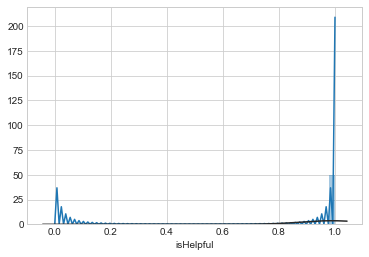

In [10]:
from scipy.stats import norm, skew

# Lets explore the distribution of the helpfulness target variable
sns.distplot(dataset['isHelpful'], fit=norm)

The target variable distribution is not uniform. We will use SMOTE and random undersampling for balancing the dataset

##### Custom Feature Extraction 

In [11]:
# This utility will generate the difference between the first review and the corresponding review days difference.
def getReviewTimeDifferenceFromMin(dataset):
    dataset['reviewTime'] = pd.to_datetime(dataset['reviewTime'])
    dataset['firstReviewTime'] = dataset.groupby(['asin'])['reviewTime'].transform(min)
    dataset['review_first_diff'] = (dataset['reviewTime'] - dataset['firstReviewTime']).astype('timedelta64[D]')
    dataset = dataset.drop(columns = ['firstReviewTime', 'reviewTime'])
    
    return dataset

In [12]:
# This utility will count the sentences in the review text
def countReviewSentence(dataset):
    pun_sen = ['.', '!', '?']
    text_col = dataset['reviewText']
    sentence_counts = []
    for i in text_col:
        sentence_count = []
        for j in pun_sen:
            count_a = i.count(j)
            sentence_count.append(count_a)
        sentence_counts.append(sum(sentence_count))
    dataset['reviewSentencesCount'] = sentence_counts
    return dataset

In [13]:
# This utiity will generate the no of characters present in review text.
# This will be used in determining the readability of each review
punctuation = ['!','"','#','$','%','&',"'",'(',')','*','+',',','-','.','/',':',';','<','=','>','?','@','[','\\',']','^','_','`','{','|','}','~','``',"''",'--']
def count_characters(dataset):
    reviewcharacters = []
    text_col = dataset['reviewText']
    for i in text_col:
        a = dict(Counter(i))
        b = {k:v for k, v in a.items() if k not in punctuation}
        c = sum(list(b.values()))
        reviewcharacters.append(c)
    dataset['reviewChars'] = reviewcharacters
    return dataset

In [14]:
# Readability of each review (ARI as index to measure)
def readability(dataset):
    wordperSen = []
    charperWord = []
    reviewRead = []
    len_df = len(dataset)
    dataset['reviewTextWordCount'] = dataset['reviewText'].apply(lambda x: len(x.split()))
    a = list(dataset['reviewTextWordCount'])
    b = list(dataset['reviewSentencesCount'])
    c = list(dataset['reviewChars'])
    for i in range(len_df):
        if b[i] == 0:
            wordperSen.append(0)
        else:
            j = a[i] / b[i]
            wordperSen.append(j)
        if a[i] == 0:
            charperWord.append(0)
        else:
            l = c[i] / a[i]
            charperWord.append(l)
        ari = 4.71 * charperWord[i] + 0.5 * wordperSen[i] - 21.43
        reviewRead.append(ari)
    dataset['reviewReadability'] = reviewRead
    return dataset

In [15]:
# drop extra features in the dataset
def drop_extra_features(dataset):
    dataset = dataset.drop(columns = ['asin', 'reviewerName', 'reviewerID','summary','unixReviewTime', 'reviewTextWordCount','overall',  'reviewSentencesCount', 'reviewChars'], axis = 1)
    
    return dataset

In [16]:
# This function will get all the customised features
def getCustomFeatures(dataset):
    
    dataset = getReviewTimeDifferenceFromMin(dataset)
    dataset = countReviewSentence(dataset)
    dataset = count_characters(dataset)
    dataset = readability(dataset)
    dataset = drop_extra_features(dataset)
    
    return dataset

##### Defining Text Normalizer 

In [17]:
def clean_text(x):

    x = str(x)
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in '&':
        x = x.replace(punct, f' {punct} ')
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
        x = x.replace(punct, '')
    return x

contraction_dict = {"aint": "is not", "arent": "are not","cant": "cannot", "'cause": "because", "couldve": "could have", "couldnt": "could not", "didnt": "did not",  "doesnt": "does not", "dont": "do not", "hadnt": "had not", "hasnt": "has not", "havent": "have not", "wasnt": "was not", "isnt": "is not", "shouldnt": "should not", "thats": "that is"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

# Misspelling corrections
mispell_dict = {"complis": "complies", "wellmade": "well-made", "onoff": "on/off", "kitchenaid": "kitchemaid", "roomba": "room", "appare": "apparel", "bodrum": "bodrum", "notly": "hotly", "kcup": "cup", "kcups": "cups", "krups": "cups", "roomthe":"room the"}
def _get_mispell(contraction_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

mispellings, mispellings_re = _get_mispell(mispell_dict)

def replace_typical_mispell(text):
    def replace(match):
        return mispellings[match.group(0)]
    return mispellings_re.sub(replace, text)

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_text(text):
    # lower case and remove special characters\whitespaces
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = text.lower()
    text = text.strip()
    text = clean_text(text)
    text = replace_contractions(text)
    text = replace_typical_mispell(text)
    # tokenize document
    tokens = wpt.tokenize(text)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    text = ' '.join(filtered_tokens)
    return text

In [18]:
#def get_normalize_text_data(run='train'):
def get_normalize_text_data(dataset):
    dataset['normalize_review_text'] = dataset['reviewText'].apply(lambda x: normalize_text(x))
    dataset = dataset.drop(columns=['reviewText'])
    
    return dataset

##### Feature Aggregation

In [19]:
# Generate the custom features
dataset = getCustomFeatures(dataset)
# Generate the normalize text feature
dataset = get_normalize_text_data(dataset)
dataset.head(1)

,isHelpful,review_first_diff,reviewReadability,normalize_review_text
0,1,640.0,12.653924,shortage pop recipes available free web purcha...


##### Train-Test Split Data 

In [20]:
from sklearn.model_selection import train_test_split

X = dataset[['review_first_diff', 'reviewReadability', 'normalize_review_text']]
y = dataset['isHelpful']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18409 entries, 11206 to 23654
Data columns (total 3 columns):
review_first_diff        18409 non-null float64
reviewReadability        18409 non-null float64
normalize_review_text    18409 non-null object
dtypes: float64(2), object(1)
memory usage: 575.3+ KB


In [21]:
#from imblearn.over_sampling import SMOTENC
# define pipeline
#over = SMOTENC(sampling_strategy=0.1)
#under = RandomUnderSampler(sampling_strategy=0.5)
#steps = [('o', over), ('u', under)]
#pipeline = Pipeline(steps=steps)

#print("Before OverSampling, counts of label '1': {}".format(sum(y == 1))) 
#print("Before OverSampling, counts of label '0': {} \n".format(sum(y == 0))) 


In [22]:
# transform the dataset
#X_list = np.array(list(X)).reshape(-1, 1)
#X_res, y_res = pipeline.fit_resample(X_list, y)

#print("After OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
#print("After OverSampling, counts of label '0': {} \n".format(sum(y_train == 0))) 


##### Feature Union and Function Transformer 

In [23]:
from sklearn.base import TransformerMixin

class ColumnExtractor(TransformerMixin):

    def __init__(self, cols):
        self.cols = cols

    def fit(self, X, y=None):
        # stateless transformer
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Xcols = X[self.cols]
        return Xcols

In [24]:
class TextTFIDFVectorizer(TransformerMixin):
    
    def __init__(self):
        self.vec = None

    def fit(self, X, y=None):
        # stateless transformer
        self.vec =TfidfVectorizer(min_df=0.01, max_df=1., ngram_range=(1, 1))
        self.vec.fit(X['normalize_review_text'])
        return self
    
    def transform(self, X):
        # assumes X is a DataFrame
        # Defining the Tfidf vectorizer
        #vectorizer = TfidfVectorizer(min_df=0.01, max_df=1., ngram_range=(1, 1))
        #fit the vectorizers to the data.
        features = self.vec.transform(X['normalize_review_text'])
    
        return features
        

In [25]:
class TextWord2Vectorizer(TransformerMixin):
    def __init__(self):
        self.word2vec = None
        
    def _col_transform(self, words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,),dtype="float64")
        nwords = 0.
    
        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model[word])

        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        wpt = nltk.WordPunctTokenizer()
        tokenized_corpus = [wpt.tokenize(document) for document in X['normalize_review_text']] 
        
        # Set values for various parameters
        feature_size = 100    # Word vector dimensionality  
        window_context = 5    # Context window size                                                                                    
        min_word_count = 2    # Minimum word count                        
        sample = 1e-3         # Downsample setting for frequent words

        self.word2vec = Word2Vec(tokenized_corpus, size=feature_size, 
                                      window=window_context, min_count = min_word_count,
                                      sample=sample, iter=10)
        
        vocabulary = set(self.word2vec.wv.index2word)
        features = [self._col_transform(tokenized_sentence, self.word2vec, vocabulary, num_features=100)
                    for tokenized_sentence in tokenized_corpus]
        return np.array(features)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [26]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


NUM_FEATURES = ['review_first_diff', 'reviewReadability']
TEXT_FEATURE = ['normalize_review_text']

process_and_join_features_tfidf = FeatureUnion(
                            transformer_list=[
                                ('numeric_feaures', Pipeline([
                                    ('selector', ColumnExtractor(NUM_FEATURES)), 
                                    ('scale', StandardScaler())
                                ])),
                                ('text_features', Pipeline([
                                    ('selector', ColumnExtractor(TEXT_FEATURE)),
                                    ('vectorizer',TextTFIDFVectorizer())
                                ]))
                            ])


process_and_join_features_word2vec = FeatureUnion(
                            transformer_list=[
                                ('numeric_feaures', Pipeline([
                                    ('selector', ColumnExtractor(NUM_FEATURES)), 
                                    ('scale', StandardScaler())
                                ])),
                                ('text_features', Pipeline([
                                    ('selector', ColumnExtractor(TEXT_FEATURE)),
                                    ('vectorizer',TextWord2Vectorizer())
                                ]))
                            ])

pipe_lr_tfidf = Pipeline([
                   ('union', process_and_join_features_tfidf),
                   ('clf', LogisticRegression(random_state=42))
                ])
pipe_dt_tfidf = Pipeline([
                   ('union', process_and_join_features_tfidf),
                   ('clf', DecisionTreeClassifier(random_state=42))
                ])
pipe_lr_word2vec = Pipeline([
                   ('union', process_and_join_features_word2vec),
                   ('clf', LogisticRegression(random_state=42))
                ])
pipe_dt_word2vec = Pipeline([
                   ('union', process_and_join_features_word2vec),
                   ('clf', DecisionTreeClassifier(random_state=42))
                ])


#### Select Base Model 

In [27]:
from sklearn.metrics import roc_auc_score

def train_predict_pipeline(pipeline):
    pipeline.fit(X_train, y_train)
    y_pred_train = pipeline.predict(X_train)
    #Evaluate model
    p_pred_test = pipeline.predict_proba(X_test)[:, 1]
    auc_test = roc_auc_score(y_test, p_pred_test)
    print('Test set accuracy score: %.3f ' % auc_test)
    
clf_pipeline = [pipe_lr_tfidf, pipe_dt_tfidf, pipe_lr_word2vec, pipe_dt_word2vec]
clf_dict = {0: 'TF-IDF Logistic Regression', 1: 'TF-IDF Decision Tree', 2: 'Word2Vec Logistic Regression',
             3: 'Word2Vec Decision Tree'}

In [28]:
for idx, clf_pipe in enumerate(clf_pipeline):
    print('Predicting test accuracy using : %s' % clf_dict[idx])
    train_predict_pipeline(clf_pipe)    

Predicting test accuracy using : TF-IDF Logistic Regression
Test set accuracy score: 0.841 
Predicting test accuracy using : TF-IDF Decision Tree
Test set accuracy score: 0.556 
Predicting test accuracy using : Word2Vec Logistic Regression
Test set accuracy score: 0.760 
Predicting test accuracy using : Word2Vec Decision Tree
Test set accuracy score: 0.518 


Based on the above test accuracy test, TFIDF Logistic Regression has performed better than rest all models.
So in the next step, we will try to optimize the test accuracy by Cross-validation using GridSearchCV

In [29]:
from sklearn.metrics import accuracy_score,precision_score,classification_report

def perform_model_optimization(grids, grid_dict):
    # Fit the grid search objects
    print('Performing model optimizations...')
    best_acc = 0.0
    best_clf = 0
    best_gs = ''
    for idx, gs in enumerate(grids):
        print('\nEstimator: %s' % grid_dict[idx])
        # Fit grid search
        gs.fit(X_train, y_train)
        # Best params
        print('Best params: %s' % gs.best_params_)
        # Best training data accuracy
        print('Best training accuracy: %.3f' % gs.best_score_)
        # Predict on test data with best params
        y_pred = gs.predict(X_test)
        # Test data accuracy of model with best params
        print('Test set precision score for best params: %.3f ' % precision_score(y_test, y_pred))
        print('Classification report :')
        print(classification_report(y_test, y_pred))
        # Track best (highest test accuracy) model
        if precision_score(y_test, y_pred) > best_acc:
            best_acc = precision_score(y_test, y_pred)
            best_gs = gs
            best_clf = idx
    print('\nClassifier with best test set precision: %s' % grid_dict[best_clf])
    return (best_clf,best_gs)

In [30]:
from sklearn.model_selection import GridSearchCV

# Set grid search params
param_range_fl = [1.0, 0.5, 0.1]

grid_params_lr = [{'clf__penalty': ['l1', 'l2'],
        'clf__C': param_range_fl,
        'clf__solver': ['liblinear']}] 

In [31]:
gs_lr_tfidf = GridSearchCV(estimator=pipe_lr_tfidf,
                     param_grid=grid_params_lr,
                     scoring='accuracy',cv=5)

In [32]:
# List of pipelines for ease of iteration
grids = [gs_lr_tfidf]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'TF-IDF Logistic Regression'}


In [33]:
perform_model_optimization(grids, grid_dict)

Performing model optimizations...

Estimator: TF-IDF Logistic Regression
Best params: {'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best training accuracy: 0.987
Test set precision score for best params: 0.988 
Classification report :
              precision    recall  f1-score   support

           0       1.00      0.02      0.04       107
           1       0.99      1.00      0.99      8961

    accuracy                           0.99      9068
   macro avg       0.99      0.51      0.52      9068
weighted avg       0.99      0.99      0.98      9068


Classifier with best test set precision: TF-IDF Logistic Regression


(0, GridSearchCV(cv=5, error_score=nan,
              estimator=Pipeline(memory=None,
                                 steps=[('union',
                                         FeatureUnion(n_jobs=None,
                                                      transformer_list=[('numeric_feaures',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('selector',
                                                                                          <__main__.ColumnExtractor object at 0x000001C40AE8ADD8>),
                                                                                         ('scale',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                        

Based on the classification report printed above, though we have high precision or accuracy of about 99%, still its not properly build as the ratio of helpfulness and not helpfulness data is highly skewed with high number of helpfulness label data  compared to not helpful data. In this case we will perform over-sampling of minority data(not helpful data) so that the data distribution is symmetric using SMOTE.

In [34]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline

pipe_lr_tfidf_random_sampling = Pipeline([
                   ('union', process_and_join_features_tfidf),
                   ('random_sampling', RandomOverSampler(random_state=777)),
                   ('clf', LogisticRegression(random_state=42))
                ])
pipe_lr_tfidf_smote_sampling = Pipeline([
                   ('union', process_and_join_features_tfidf),
                   ('random_sampling', SMOTE(random_state=777)),
                   ('clf', LogisticRegression(random_state=42))
                ])

In [35]:
gs_lr_tfidf_random_sampling = GridSearchCV(estimator=pipe_lr_tfidf_random_sampling,
                     param_grid=grid_params_lr,
                     scoring='accuracy',cv=5)
gs_lr_tfidf_smote_sampling = GridSearchCV(estimator=pipe_lr_tfidf_smote_sampling,
                     param_grid=grid_params_lr,
                     scoring='accuracy',cv=5)

In [36]:
# List of pipelines for ease of iteration
grids_sampling = [gs_lr_tfidf_random_sampling, gs_lr_tfidf_smote_sampling]

# Dictionary of pipelines and classifier types for ease of reference
grid_sampling_dict = {0: 'Random Oversampling TF-IDF Logistic Regression', 1: 'SMOTE Oversampling TF-IDF Logistic Regression'}


In [37]:
best_clf,best_gs = perform_model_optimization(grids_sampling, grid_sampling_dict)

Performing model optimizations...

Estimator: Random Oversampling TF-IDF Logistic Regression
Best params: {'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best training accuracy: 0.956
Test set precision score for best params: 0.992 
Classification report :
              precision    recall  f1-score   support

           0       0.10      0.38      0.16       107
           1       0.99      0.96      0.98      8961

    accuracy                           0.95      9068
   macro avg       0.55      0.67      0.57      9068
weighted avg       0.98      0.95      0.97      9068


Estimator: SMOTE Oversampling TF-IDF Logistic Regression
Best params: {'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best training accuracy: 0.956
Test set precision score for best params: 0.993 
Classification report :
              precision    recall  f1-score   support

           0       0.11      0.39      0.17       107
           1       0.99      0.96      0.98      

In [38]:
from sklearn.externals import joblib
# Save best grid search pipeline to file
dump_file = 'best_gs_pipeline.pkl'
joblib.dump(best_gs, dump_file, compress=1)
print('\nSaved %s grid search pipeline to file: %s' % (grid_sampling_dict[best_clf], dump_file))


Saved SMOTE Oversampling TF-IDF Logistic Regression grid search pipeline to file: best_gs_pipeline.pkl


Based on the our analysis, using SMOTE Oversampling TFIDF Logistic Regression, we got the highest precision of around 99%.